In [1]:
%load_ext autoreload
%autoreload 2

import torch
from teren import utils as teren_utils
import seaborn as sns
import plotly_express as px

device = teren_utils.get_device_str()
print(f"{device=}")

device='cuda'


In [2]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
# each layer is kind of independent experiment, but we save a lot of time by
# collecting dataset examples and residual stream activation for many layers at once

LAYERS = list(range(model.cfg.n_layers))
# LAYERS = 0, 5, 10

# pre-trained SAE model availavle in SAELens
SAE_RELEASE = "gpt2-small-res-jb"
LAYER_TO_SAE_ID = lambda layer: f"blocks.{layer}.hook_resid_pre"

# HF text  dataset
DATASET_PATH = "NeelNanda/c4-10k"
DATASET_SPLIT = "train[:1%]"

# how long each tokenized prompt should be
CONTEXT_SIZE = 32

# how many tokens can be forwarded through the transformer at once
# tune to your VRAM, 12_800 works well with 16GB
INFERENCE_TOKENS = 320 # 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // CONTEXT_SIZE
print(f"{INFERENCE_BATCH_SIZE=}")

# what is the minimum activation for a feature to be considered active
MIN_FEATURE_ACTIVATION = 0.0
# minimum number of tokenized prompts that should have a feature active
# for the feature to be included in the experiment
MIN_EXAMPLES_PER_FEATURE = 30
# ids of feature to consider in the experiment
# we can't consider all the features, because of compute & memory constraints
CONSIDER_FEATURE_IDS = range(30)

INFERENCE_BATCH_SIZE=10


In [4]:
from sae_lens import SAE

saes = [
    # ignore other things it returns
    SAE.from_pretrained(
        release=SAE_RELEASE, sae_id=LAYER_TO_SAE_ID(layer), device=device
    )[0]
    for layer in LAYERS
]

In [5]:
all_input_ids = teren_utils.load_and_tokenize_dataset(
    path=DATASET_PATH,
    split=DATASET_SPLIT,
    column_name="text",
    tokenizer=model.tokenizer,
    max_length=CONTEXT_SIZE,
)
print(f"all_input_ids (tokenized dataset) shape: {tuple(all_input_ids.shape)}")

all_input_ids (tokenized dataset) shape: (1582, 32)


In [6]:
from teren.sae_examples import get_examples_by_feature_by_sae, SAEExamplesByFeature

examples_by_feature_by_sae: list[SAEExamplesByFeature] = get_examples_by_feature_by_sae(
    input_ids=all_input_ids,
    model=model,
    saes=saes,
    feature_ids=CONSIDER_FEATURE_IDS,
    n_examples=MIN_EXAMPLES_PER_FEATURE,
    batch_size=INFERENCE_BATCH_SIZE,
    min_activation=MIN_FEATURE_ACTIVATION,
)

# display high-level summary of the data
for layer, examples_by_feature in zip(LAYERS, examples_by_feature_by_sae):
    print(f"Layer: {layer}")
    active_feature_ids = examples_by_feature.active_feature_ids
    print(f"Number of selected features: {len(active_feature_ids)}")
    print(f"Active feature ids: {active_feature_ids}")
    print()

Layer: 0
Number of selected features: 1
Active feature ids: [9]

Layer: 1
Number of selected features: 1
Active feature ids: [11]

Layer: 2
Number of selected features: 1
Active feature ids: [0]

Layer: 3
Number of selected features: 2
Active feature ids: [6, 24]

Layer: 4
Number of selected features: 5
Active feature ids: [7, 8, 12, 15, 19]

Layer: 5
Number of selected features: 14
Active feature ids: [0, 2, 4, 5, 9, 10, 13, 15, 19, 24, 25, 26, 27, 28]

Layer: 6
Number of selected features: 10
Active feature ids: [5, 7, 9, 13, 14, 16, 17, 18, 20, 27]

Layer: 7
Number of selected features: 15
Active feature ids: [0, 3, 4, 5, 6, 10, 14, 17, 18, 20, 21, 22, 23, 26, 29]

Layer: 8
Number of selected features: 19
Active feature ids: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 21, 22, 24, 25, 26, 29]

Layer: 9
Number of selected features: 22
Active feature ids: [0, 2, 4, 5, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29]

Layer: 10
Number of selected features: 15
Activ

In [7]:
def print_examples_shapes(idx):
    print(f"Layer: {LAYERS[idx]}")
    examples_by_feature = examples_by_feature_by_sae[idx]
    print(f"input_ids shape: {tuple(examples_by_feature.input_ids.shape)} (n_features, n_examples, context_size)")
    print(f"resid_acts shape: {tuple(examples_by_feature.resid_acts.shape)} (n_features, n_examples, context_size, d_model)")
    print(f"clean_loss shape: {tuple(examples_by_feature.clean_loss.shape)} (n_features, n_examples, context_size - 1)")

print_examples_shapes(0)

Layer: 0
input_ids shape: (1, 30, 32) (n_features, n_examples, context_size)
resid_acts shape: (1, 30, 32, 768) (n_features, n_examples, context_size, d_model)
clean_loss shape: (1, 30, 31) (n_features, n_examples, context_size - 1)


In [8]:
import torch
from dataclasses import dataclass
from typing import Any
import matplotlib.pyplot as plt
import numpy as np
from teren.perturbations import Perturbation
import torch.nn.functional as F
from jaxtyping import Float, Int
from contextlib import contextmanager
from sklearn.decomposition import PCA

import umap

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


In [9]:
def plot_kl_divergence_trajectories_plotly(kl_divs_by_direction, sae_idx, feature_id):
    # Prepare data for plotting
    data = []
    max_kl_div = max([kl_divs.max().item() for kl_divs in kl_divs_by_direction])
    for direction_idx, kl_divs in enumerate(kl_divs_by_direction):
        angle = 2 * np.pi * direction_idx / len(kl_divs_by_direction)
        x = [step * np.cos(angle) for step in range(len(kl_divs))]
        y = [step * np.sin(angle) for step in range(len(kl_divs))]
        
        for step, (xi, yi, kl) in enumerate(zip(x, y, kl_divs)):
            data.append({
                'x': xi,
                'y': yi,
                'kl_div': round(kl.item(), 4),
                'direction': f'Direction {direction_idx}',
                'step': step,
                'size': round(kl.item() / max_kl_div, 4)
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Create the scatter plot
    fig = px.scatter(df, x='x', y='y', color='direction', size='size',
                     hover_data=['step', 'kl_div'],
                     labels={'x': 'Direction 1', 'y': 'Direction 2'},
                     title=f'KL Divergence Trajectories - SAE {sae_idx}, Feature {feature_id}',
                     size_max=5)  # Adjust the maximum size of the points
    
    
    # Calculate the plot bounds
    max_abs_coord = df[['x', 'y']].abs().max().max()
    axis_range = [-max_abs_coord * 1.1, max_abs_coord * 1.1]
    
    # Update layout for better appearance
    fig.update_layout(
        xaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=axis_range),
        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=axis_range, scaleanchor="x", scaleratio=1),
        showlegend=True,
        legend_title_text='Directions',
        hovermode='closest',
        width=800,  # Set width
        height=800  # Set height to be equal to width for a square plot
    )
    
    # Show the plot
    fig.show()

In [10]:
def is_normalized(vector, tolerance=1e-6):
    return torch.isclose(vector.norm(), torch.tensor(1.0), atol=tolerance)


@dataclass
class FeatureToRandomPerturbation:
    sae: SAE
    feature_idx: int
    random_direction: torch.Tensor
    num_steps: int
    scale_factor: float = 1.0

    def __post_init__(self):
        assert is_normalized(self.random_direction.norm()), "Random direction is not normalised"
        self.feature_direction = self.sae.W_dec[self.feature_idx]
        self.feature_norm = self.feature_direction.norm()
        self.scaled_random_direction = self.random_direction * self.feature_norm
        print(f"Feature direction norm: {self.feature_norm.item()}")
        print(f"Scaled random direction norm: {self.scaled_random_direction.norm().item()}")
        sim = F.cosine_similarity(self.feature_direction.flatten(), self.scaled_random_direction.flatten(), dim=0).item()
        print(f"Cosine similarity between feature and random: {sim}")

    def generate(self, step):
        alpha = step / self.num_steps
        
        # Interpolate between feature direction and random direction
        perturb_direction = (1 - alpha) * self.feature_direction + alpha * self.scaled_random_direction

        print(f"Step {step}, Perturbation norm: {perturb_direction.norm().item()}")

        # Scale the perturbation by the feature norm
        return perturb_direction * self.scale_factor


@dataclass
class SphericalFeatureToRandomPerturbation:
    sae: SAE
    feature_idx: int
    normalised_random_direction: torch.Tensor
    num_steps: int
    scale_factor: float = 1.0

    def __post_init__(self):
        assert is_normalized(self.normalised_random_direction.norm()), "Random direction is not normalised"
        self.feature_direction = self.sae.W_dec[self.feature_idx]
        self.feature_norm = self.feature_direction.norm()
        self.normalized_feature_direction = self.feature_direction / self.feature_norm

    def slerp(self, start, end, t):
        omega = torch.acos((start * end).sum())
        so = torch.sin(omega)
        return torch.sin((1.0 - t) * omega) / so * start + torch.sin(t * omega) / so * end

    def generate(self, step):
        alpha = step / self.num_steps

        interpolated_direction = self.slerp(self.normalized_feature_direction, 
                                            self.normalised_random_direction, 
                                            alpha)
        
        # Scale the interpolated direction and apply scale factor
        return interpolated_direction * self.feature_norm * self.scale_factor

In [11]:
@contextmanager
def torch_gc():
    try:
        yield
    finally:
        torch.cuda.empty_cache()


def cosine_similarity_matrix(vectors):
    # Normalize the vectors
    normalized = F.normalize(vectors, p=2, dim=1)
    # Compute the cosine similarity matrix
    cosine_sim = torch.mm(normalized, normalized.t())
    return cosine_sim

def check_orthogonality(random_directions, threshold=0.1):
    cosine_sim = cosine_similarity_matrix(random_directions)
    
    # Set diagonal to 0 (ignore self-similarity)
    cosine_sim.fill_diagonal_(0)
    
    # Check if any off-diagonal element exceeds the threshold
    max_similarity = cosine_sim.abs().max().item()
    is_orthogonal = max_similarity <= threshold
    
    # print(f"Maximum absolute cosine similarity: {max_similarity:.4f}")
    # print(f"Directions are {'approximately orthogonal' if is_orthogonal else 'not orthogonal'}")
    
    # # Optionally, print the full similarity matrix
    # print("\nCosine similarity matrix:")
    # print(cosine_sim)
    
    return is_orthogonal, cosine_sim


def get_feature_to_random_perturbations(sae, feature_idx, num_directions, num_steps, scale_factor=1.0, use_slerp=False):
    random_directions = torch.randn(num_directions, sae.W_dec.shape[1], device=device)
    random_directions = random_directions / random_directions.norm(p=2, dim=1, keepdim=True)

    is_orthogonal, cosine_sim = check_orthogonality(random_directions)
    if not is_orthogonal:
        print(f"Warning: Random directions are not approximately orthogonal. {cosine_sim}")
    
    PerturbationClass = SphericalFeatureToRandomPerturbation if use_slerp else FeatureToRandomPerturbation
    
    return [PerturbationClass(sae, feature_idx, random_direction, num_steps, scale_factor)
            for random_direction in random_directions]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(logprobs_pert, logprobs_ref, log_target=True, reduction="none")
    return temp_output.sum(dim=-1)

def compute_pert_vectors(
    pert_by_feature_id: dict[int, dict[int, Perturbation]],
    examples_by_feature: SAEExamplesByFeature,
    current_step: int
):
    # (feature, batch, n_ctx, d_model)
    pert_vectors = torch.empty_like(examples_by_feature.resid_acts, device=device)
    
    for idx, feature_id in enumerate(examples_by_feature.active_feature_ids):
        if feature_id in pert_by_feature_id:
            pert = pert_by_feature_id[feature_id][current_step]
            resid_acts = examples_by_feature.resid_acts[idx]
            perturb = pert(resid_acts)
            pert_vectors[idx] = perturb
        else:
            # If no perturbation is defined for this feature, use zeros
            pert_vectors[idx] = torch.zeros_like(examples_by_feature.resid_acts[idx])
    
    return pert_vectors


def compute_logits(
    model: HookedTransformer,
    input_ids: Int[torch.Tensor, "*batch seq"],
    resid_acts: Float[torch.Tensor, "*batch seq d_model"],
    start_at_layer: int,
    batch_size: int,
) -> Float[torch.Tensor, "*batch seq vocab"]:
    assert input_ids.shape == resid_acts.shape[:-1], f"{input_ids.shape=} {resid_acts.shape=}"

    batch_shape = input_ids.shape[:-1]
    d_seq, d_model = resid_acts.shape[-2:]
    resid_acts_flat = resid_acts.view(-1, d_seq, d_model)

    logits_list = []

    for i in range(0, resid_acts_flat.shape[0], batch_size):
        batch_resid_acts_flat = resid_acts_flat[i : i + batch_size].to(device)

        logits = model(
            batch_resid_acts_flat,
            start_at_layer=start_at_layer,
        )
        logits_list.append(logits)  # Remove .cpu() to keep tensors on the same device
    logits_flat = torch.cat(logits_list, dim=0)
    logits_shape = batch_shape + (d_seq, -1)  # -1 for vocab size
    
    return logits_flat.view(logits_shape)


def get_pert_kl_div(
    sae: SAE, 
    examples_by_feature: SAEExamplesByFeature, 
    pert_vec: torch.Tensor,
    base_logits: torch.Tensor
) -> torch.Tensor:

    with torch_gc():
        device = pert_vec.device
        resid_acts = examples_by_feature.resid_acts.to(device)
        
        perturbed_logits = compute_logits(
            model=model,
            input_ids=examples_by_feature.input_ids.to(device),
            resid_acts=resid_acts + pert_vec,
            start_at_layer=sae.cfg.hook_layer,
            batch_size=INFERENCE_BATCH_SIZE,
        )

        # base_probs = F.softmax(base_logits, dim=-1)
        # pert_probs = F.softmax(perturbed_logits, dim=-1)
        # print(f"Base logits max/min: {base_logits.max().item():.4f}/{base_logits.min().item():.4f}")
        # print(f"Pert logits max/min: {perturbed_logits.max().item():.4f}/{perturbed_logits.min().item():.4f}")
        # print(f"Base probs max/min: {base_probs.max().item():.4f}/{base_probs.min().item():.4f}")
        # print(f"Pert probs max/min: {pert_probs.max().item():.4f}/{pert_probs.min().item():.4f}")

        
        # Move to CPU for KL divergence computation
        kl_div = compute_kl_div(base_logits.cpu(), perturbed_logits.cpu())
        
        # Average over all dimensions except the first (feature dimension)
        return kl_div.mean(dim=tuple(range(1, kl_div.dim())))
    
def compute_trajectory_kl_divs(
    sae: SAE, 
    examples_by_feature: SAEExamplesByFeature, 
    perturbations: list,
    num_steps: int
):
    with torch_gc():
        input_ids = examples_by_feature.input_ids.to(device)
        resid_acts = examples_by_feature.resid_acts.to(device)
        
        base_logits = compute_logits(
            model=model,
            input_ids=input_ids,
            resid_acts=resid_acts,
            start_at_layer=sae.cfg.hook_layer,
            batch_size=INFERENCE_BATCH_SIZE,
        ).cpu()

        kl_divs_by_direction = []
        trajectories_by_direction = []

        for pert in perturbations:
            kl_divs = []
            trajectory = []
            
            for step in range(num_steps + 1):  # +1 to include the starting point
                with torch_gc():
                    pert_vec = pert.generate(step)
                    
                    perturbed_vector = resid_acts + pert_vec
                    kl_div = get_pert_kl_div(sae, examples_by_feature, pert_vec, base_logits)
                    # print(f"Step {step}, KL div: {kl_div.item()}, Perturbation norm: {pert_vec.norm().item()}")

                    kl_divs.append(kl_div)
                    trajectory.append(perturbed_vector.cpu())
                    
                    del pert_vec
                    torch.cuda.empty_cache()
            
            kl_divs_by_direction.append(torch.stack(kl_divs))
            trajectories_by_direction.append(torch.stack(trajectory))

        return kl_divs_by_direction, trajectories_by_direction

In [12]:
# Choose the first SAE and its corresponding examples
sae_idx = 0
sae = saes[sae_idx]
examples_by_feature = examples_by_feature_by_sae[sae_idx]

# Choose a single feature (e.g., the first active feature)
feature_id = examples_by_feature.active_feature_ids[0]

# Create a new examples_by_feature with only one feature
single_feature_examples = SAEExamplesByFeature(
    active_feature_ids=[feature_id],
    input_ids=examples_by_feature.input_ids[:1],
    resid_acts=examples_by_feature.resid_acts[:1],
    clean_loss=examples_by_feature.clean_loss[:1] if examples_by_feature.clean_loss is not None else None
)

In [13]:
# def check_model_response(sae, examples_by_feature, perturbation_scale=0.1):
#     resid_acts = examples_by_feature.resid_acts.to(device)
#     base_logits = compute_logits(model, examples_by_feature.input_ids.to(device), resid_acts, sae.cfg.hook_layer, INFERENCE_BATCH_SIZE)
    
#     # No perturbation
#     print("No perturbation:")
#     print_logits_info(base_logits)
    
#     # Constant perturbation
#     const_pert = torch.randn_like(resid_acts) * perturbation_scale
#     pert_logits = compute_logits(model, examples_by_feature.input_ids.to(device), resid_acts + const_pert, sae.cfg.hook_layer, INFERENCE_BATCH_SIZE)
#     print(f"\nConstant perturbation (scale {perturbation_scale}):")
#     print_logits_info(pert_logits)
    
#     kl_div = compute_kl_div(base_logits, pert_logits)
#     print(f"KL divergence: {kl_div.mean().item():.6f}")

# def print_logits_info(logits):
#     probs = F.softmax(logits, dim=-1)
#     print(f"Logits max/min: {logits.max().item():.4f}/{logits.min().item():.4f}")
#     print(f"Probs max/min: {probs.max().item():.4f}/{probs.min().item():.4f}")

# check_model_response(sae, single_feature_examples)

In [14]:
# # Set up parameters
# num_directions = 5
# num_steps = 10
# scale_factors = [1.0, 2.0, 5.0]  # Different scale factors to try
# use_slerp_options = [False, True]  # Try both regular and spherical interpolation


# for scale_factor in scale_factors:
#     for use_slerp in use_slerp_options:
#         print(f"\nExperiment with scale_factor={scale_factor}, use_slerp={use_slerp}")
        
#         # Generate perturbations
#         perturbations = get_feature_to_random_perturbations(sae, feature_id, num_directions, num_steps, scale_factor, use_slerp)
        
#         # Compute KL divergences
#         kl_divs, trajectories = compute_trajectory_kl_divs(sae, single_feature_examples, perturbations, num_steps)
        
#         # Print summary statistics
#         for direction_idx, direction_kl_divs in enumerate(kl_divs):
#             print(f"Direction {direction_idx}:")
#             print(f"  Initial KL div: {direction_kl_divs[0].item():.6f}")
#             print(f"  Min KL div: {direction_kl_divs.min().item():.6f}")
#             print(f"  Max KL div: {direction_kl_divs.max().item():.6f}")
#             print(f"  Final KL div: {direction_kl_divs[-1].item():.6f}")

## Generating Random Directions & Finding Interesting Directions

In [291]:
num_directions = 50
num_steps = 10
scale_factor = 2.0
use_slerp = True

# Choose the first SAE and its corresponding examples
sae_idx = 11
sae = saes[sae_idx]
examples_by_feature = examples_by_feature_by_sae[sae_idx]

# Choose a single feature (e.g., the first active feature)
feature_id = examples_by_feature.active_feature_ids[0]

# Create a new examples_by_feature with only one feature
single_feature_examples = SAEExamplesByFeature(
    active_feature_ids=[feature_id],
    input_ids=examples_by_feature.input_ids[:1],
    resid_acts=examples_by_feature.resid_acts[:1],
    clean_loss=examples_by_feature.clean_loss[:1] if examples_by_feature.clean_loss is not None else None
)

perturbations = get_feature_to_random_perturbations(sae, feature_id, num_directions, num_steps, scale_factor, use_slerp)

# Compute KL divergences
kl_divs, trajectories = compute_trajectory_kl_divs(sae, single_feature_examples, perturbations, num_steps)

        [ 0.0282,  0.0000,  0.0016,  ...,  0.0449, -0.0261,  0.0686],
        [ 0.0065,  0.0016,  0.0000,  ..., -0.0140, -0.0200, -0.0144],
        ...,
        [-0.0128,  0.0449, -0.0140,  ...,  0.0000,  0.0194, -0.0079],
        [-0.0295, -0.0261, -0.0200,  ...,  0.0194,  0.0000, -0.0194],
        [ 0.0836,  0.0686, -0.0144,  ..., -0.0079, -0.0194,  0.0000]],
       device='cuda:0')


In [283]:
# kl_name = f"kl_divs_sae{sae_idx}_f{feature_id}_dirs{num_directions}_steps{num_steps}_scale{scale_factor}.npy"
# traj_name = f"trajectories_sae{sae_idx}_f{feature_id}_dirs{num_directions}_steps{num_steps}_scale{scale_factor}.npy"

# np.save(kl_name, np.array(kl_divs))
# np.save(traj_name, np.array(trajectories))

In [292]:
def find_interesting_directions(kl_divs_by_direction, top_k=5):
    # Convert to numpy array if it's not already
    kl_divs = np.array(kl_divs_by_direction)

    final_kl_div_per_dir = kl_divs[:, -1].squeeze()
    
    # Get the indices of the top k directions
    top_indices = np.argsort(final_kl_div_per_dir)[-top_k:][::-1]
    
    return top_indices, final_kl_div_per_dir[top_indices]

# Usage
top_indices, top_kl_divs = find_interesting_directions(kl_divs, top_k=5)
print("Indices of top directions:", top_indices)
print("Max KL divergences:", top_kl_divs)

Indices of top directions: [20 43 37  3 30]
Max KL divergences: [0.0001908  0.00018499 0.00017754 0.00017694 0.00017613]


In [293]:
def get_interesting_directions(random_directions, top_indices):
    return [random_directions[i] for i in top_indices]

random_directions = [p.normalised_random_direction for p in perturbations]
interesting_directions = get_interesting_directions(random_directions, top_indices)

In [294]:
def analyze_activation_patterns(sae, feature_id, interesting_direction, num_steps=10):
    # Get the original feature direction
    original_feature = sae.W_dec[feature_id]
    
    # Generate perturbations along the interesting direction
    perturbations = [interesting_direction * step for step in torch.linspace(0, 1, num_steps)]
    
    # Compute activations
    activations = [sae.encode(original_feature + pert) for pert in perturbations]
    activations = [act.detach().cpu().numpy().flatten() for act in activations]
    
    # Find top k features across all steps
    top_k = 10
    all_activations = np.vstack(activations)
    top_k_indices = np.argsort(np.max(all_activations, axis=0))[-top_k:][::-1]
    
   # Plot the change in top k activations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    for i, idx in enumerate(top_k_indices):
        ax1.plot([act[idx] for act in activations], label=f'Feature {idx}')
    
    ax1.set_title(f'Top {top_k} Activation Changes Along Interesting Direction')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Activation Strength')
    ax1.legend()

    # Plot L1 norm of activation vector
    l1_norms = [np.linalg.norm(act, ord=1) for act in activations]
    ax2.plot(l1_norms)
    ax2.set_title('L1 Norm of Activation Vector')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('L1 Norm')

    plt.tight_layout()
    plt.show()


def compare_with_sae_features(sae, interesting_direction, top_k=5):
    # Normalize the interesting direction
    interesting_direction_norm = interesting_direction / torch.norm(interesting_direction)
    
    # Compute cosine similarities with all SAE features
    similarities = torch.nn.functional.cosine_similarity(
        interesting_direction_norm.unsqueeze(0),
        sae.W_dec,
        dim=1
    )
    
    # Get top k similar features
    top_k_values, top_k_indices = torch.topk(similarities, top_k)
    
    print(f"Top {top_k} similar SAE features:")
    for i, (value, index) in enumerate(zip(top_k_values, top_k_indices)):
        print(f"Rank {i+1}: Feature {index.item()}, Similarity: {value.item():.4f}")

In [295]:
def visualize_trajectories(sae, feature_id, directions, top_indices=None, num_steps=10):
    # Get the original feature direction
    original_feature = sae.W_dec[feature_id]
    
    # Generate trajectories
    trajectories = []
    for direction in directions:
        trajectory = [original_feature + direction * step for step in torch.linspace(0, 1, num_steps)]
        trajectories.append(torch.stack(trajectory))
    
    # Flatten and concatenate all trajectories
    all_points = torch.cat([traj.view(-1, traj.shape[-1]) for traj in trajectories])
    
    # Perform PCA
    pca = PCA(n_components=2)
    points_2d = pca.fit_transform(all_points.detach().cpu().numpy())
    
    # Split back into separate trajectories
    trajectories_2d = np.split(points_2d, len(directions))
    
    # Plot
    plt.figure(figsize=(12, 8))

    for i, traj in enumerate(trajectories_2d):
        if top_indices:
            plt.plot(traj[:, 0], traj[:, 1], '-o', label=f'Direction {top_indices[i]}')
        else:
            plt.plot(traj[:, 0], traj[:, 1], '-o')
    
    plt.title('Trajectories in 2D PCA Space')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()

In [296]:
# # Compare with SAE features
# for i, direction in enumerate(interesting_directions):
#     print(f"Comparing direction {i} (original index {top_indices[i]}) with SAE features:")
#     compare_with_sae_features(sae, direction)

# # Visualize trajectories
# visualize_trajectories(sae, feature_id, interesting_directions, top_indices)

In [297]:
plot_kl_divergence_trajectories_plotly(kl_divs, sae_idx, feature_id)

In [298]:
def compare_all_directions_with_sae_features(sae, directions, kl_divs, top_k=3):
    # Compute cosine similarities with all SAE features for each direction
    similarities = torch.stack([
        torch.nn.functional.cosine_similarity(d.unsqueeze(0), sae.W_dec, dim=1)
        for d in directions
    ])
    
    # Get top k similar features for each direction
    top_k_values, top_k_indices = torch.topk(similarities, top_k, dim=1)
    
    # Compute average of top k similarities for each direction
    avg_top_k_similarities = top_k_values.mean(dim=1)
    
    # Get final KL divergence for each direction
    final_kl_divs = [kd[-1].item() if torch.is_tensor(kd) else kd[-1] for kd in kl_divs]
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Direction': range(len(directions)),
        'Avg Top-k Similarity': avg_top_k_similarities.cpu().numpy(),
        'Final KL Divergence': final_kl_divs
    })
    
    # Sort by Final KL Divergence
    df = df.sort_values('Final KL Divergence', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Final KL Divergence', y='Avg Top-k Similarity', hue='Direction', palette='viridis')
    plt.title(f'Correlation between Final KL Divergence and Similarity to Top {top_k} SAE Features')
    plt.xlabel('Final KL Divergence')
    plt.ylabel(f'Average Similarity to Top {top_k} SAE Features')
    plt.show()
    
    # Print top similar features for top 5 directions by KL divergence
    print("\nTop similar SAE features for directions with highest final KL divergence:")
    for i in df['Direction'].head():
        print(f"\nDirection {i}:")
        for j, (value, index) in enumerate(zip(top_k_values[i], top_k_indices[i])):
            print(f"  Rank {j+1}: Feature {index.item()}, Similarity: {value.item():.4f}")
    
    return df, similarities

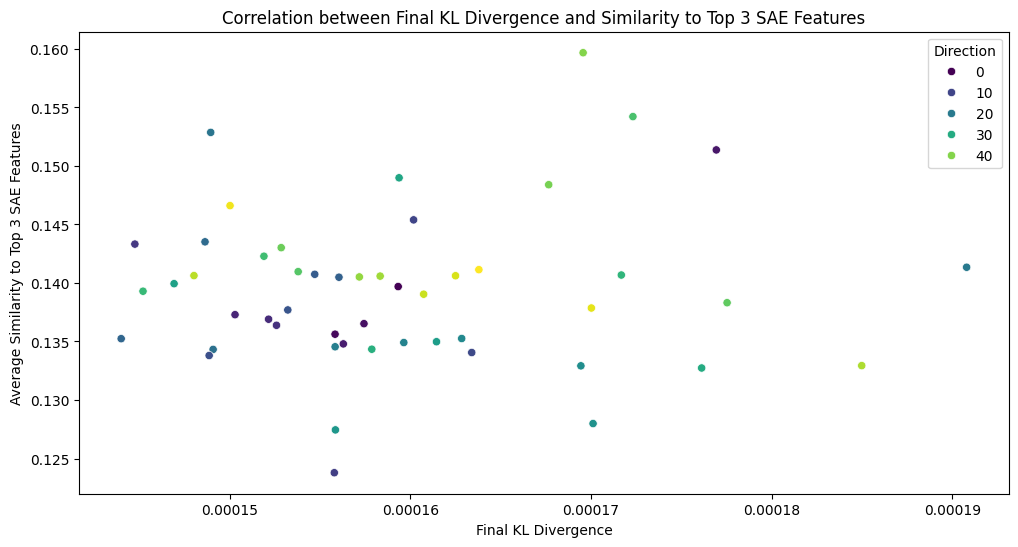


Top similar SAE features for directions with highest final KL divergence:

Direction 20:
  Rank 1: Feature 24233, Similarity: 0.1442
  Rank 2: Feature 1431, Similarity: 0.1441
  Rank 3: Feature 16771, Similarity: 0.1358

Direction 43:
  Rank 1: Feature 2136, Similarity: 0.1432
  Rank 2: Feature 5412, Similarity: 0.1319
  Rank 3: Feature 16536, Similarity: 0.1238

Direction 37:
  Rank 1: Feature 7419, Similarity: 0.1506
  Rank 2: Feature 9695, Similarity: 0.1323
  Rank 3: Feature 13801, Similarity: 0.1321

Direction 3:
  Rank 1: Feature 8439, Similarity: 0.1558
  Rank 2: Feature 23758, Similarity: 0.1512
  Rank 3: Feature 4980, Similarity: 0.1471

Direction 30:
  Rank 1: Feature 8715, Similarity: 0.1544
  Rank 2: Feature 20851, Similarity: 0.1249
  Rank 3: Feature 4151, Similarity: 0.1190


In [299]:
df, similarities = compare_all_directions_with_sae_features(sae, random_directions, kl_divs)

In [290]:
df.sort_values(by='Final KL Divergence', ascending=False).head()

,Direction,Avg Top-k Similarity,Final KL Divergence
15,15,0.139194,0.001200
5,5,0.136014,0.001140
34,34,0.135007,0.001100
47,47,0.136790,0.001068
30,30,0.155656,0.001066


## Using SGD to find directions of high KL divergence

In [92]:
import torch
import torch.nn.functional as F

def compute_kl_div(logits_p, logits_q):
    p = F.softmax(logits_p, dim=-1)
    log_p = F.log_softmax(logits_p, dim=-1)
    log_q = F.log_softmax(logits_q, dim=-1)
    return (p * (log_p - log_q)).sum(-1).mean()

def optimize_direction(sae, model, examples_by_feature, feature_id, num_steps=100, lr=0.01, batch_size=4):
    device = next(model.parameters()).device
    
    original_feature = sae.W_dec[feature_id].to(device)
    direction = torch.zeros_like(original_feature, requires_grad=True, device=device)
    
    optimizer = torch.optim.Adam([direction], lr=lr)
    
    resid_acts = examples_by_feature.resid_acts.to(device)
    
    print(f"resid_acts shape: {resid_acts.shape}")
    print(f"original_feature shape: {original_feature.shape}")
    print(f"direction shape: {direction.shape}")
    
    kl_divs_history = []
    
    for step in range(num_steps):
        optimizer.zero_grad()
        total_kl_div = 0
        
        for i in range(0, resid_acts.shape[1], batch_size):
            batch_resid_acts = resid_acts[:, i:i+batch_size].reshape(-1, resid_acts.shape[-1])
            
            # Compute logits for original feature
            with torch.no_grad():
                logits_original = model.forward(
                    batch_resid_acts + original_feature.unsqueeze(0),
                    start_at_layer=sae.cfg.hook_layer,
                    return_type="logits"
                )
            
            # Compute logits for optimized direction
            logits_optimized = model.forward(
                batch_resid_acts + direction.unsqueeze(0),
                start_at_layer=sae.cfg.hook_layer,
                return_type="logits"
            )
            
            # Compute KL divergence
            kl_div = compute_kl_div(logits_original, logits_optimized)
            total_kl_div += kl_div
        
        # Maximize KL divergence
        loss = -total_kl_div
        loss.backward()
        
        print(f"Step {step}")
        print(f"direction.grad: {direction.grad is not None}")
        print(f"KL Divergence: {total_kl_div.item():.4f}")
        
        optimizer.step()
        
        kl_divs_history.append(total_kl_div.item())
        
        if step % 10 == 0:
            print(f"Step {step}, KL Divergence: {total_kl_div.item():.4f}")
    
    return direction.detach().cpu(), kl_divs_history

In [93]:
torch.cuda.empty_cache()

In [94]:
torch.set_grad_enabled(True) 
optimized_direction, kl_divs_history = optimize_direction(
    sae, model, examples_by_feature, feature_id
)

resid_acts shape: torch.Size([1, 30, 32, 768])
original_feature shape: torch.Size([768])
direction shape: torch.Size([768])


RuntimeError: shape '[128, 768, 12, 64]' is invalid for input of size 98304

In [21]:
torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(kl_divs_history)
plt.title('Average KL Divergence During Optimization')
plt.xlabel('Optimization Step')
plt.ylabel('Average KL Divergence')
plt.show()